# Fetch Boris Johnson tweets data
In this notebook I will scrape Twitter using `snscrape`, fetching all tweets which mention "@BorisJohnson" between 2019 and 2020. 

This is a ___large___ dataset for my personal laptop to handle, and will also take a long time to scrape. For this reason, we are doing one day at a time (saving each day of tweets to a separate .json file) and apply parallel processing with `concurrent.futures` to speed it up.

First, install the latest version of `snscrape` (requires Python version 3.8 or greater).

In [1]:
%%capture
!pip install --upgrade git+https://github.com/JustAnotherArchivist/snscrape@master

In [2]:
import datetime
import os

Set up logging.

In [3]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Create logger
logging.basicConfig(
    filename='twitter_fetching_log_{}.log'.format(datetime.datetime.now().strftime('%Y-%m-%d')),
    level=logging.INFO,
    format='%(name)s - %(asctime)s - %(levelname)s - %(filename)s :  %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

logger = logging.getLogger(__name__)

Define the list of dates to fetch.

In [10]:
sdate = datetime.date(2019, 1, 1)   # start date
edate = datetime.date(2021, 1, 1)   # end date
delta = edate - sdate

dates = [sdate + datetime.timedelta(days=i) for i in range(delta.days + 1)]

Fetch all tweets, saving in JSON format. We'll apply parallelisation since it will considerably speed up the data fetching process.

In [11]:
def fetch_tweets(date, next_date):
    logger.info('Fetching tweets between {} and {}...'.format(date, next_date))
    os.system(
        'snscrape --jsonl twitter-search "@BorisJohnson since:{} until:{}" > tweets_data/tweets_{}.json'.format(
            date, next_date, date)
    )
    logger.info('Done {}.'.format(date))

In [12]:
from concurrent.futures import ThreadPoolExecutor

CONCURRENT_AT_THE_SAME_TIME = 8

with ThreadPoolExecutor(max_workers=CONCURRENT_AT_THE_SAME_TIME) as executor:
    futures = [
        executor.submit(
            fetch_tweets,
            date,
            next_date
        )

        for date, next_date in zip(dates[:-1], dates[1:])
    ]

## Data fetch checks

Check file sizes for any surprising dates which may have errored out.

<AxesSubplot:>

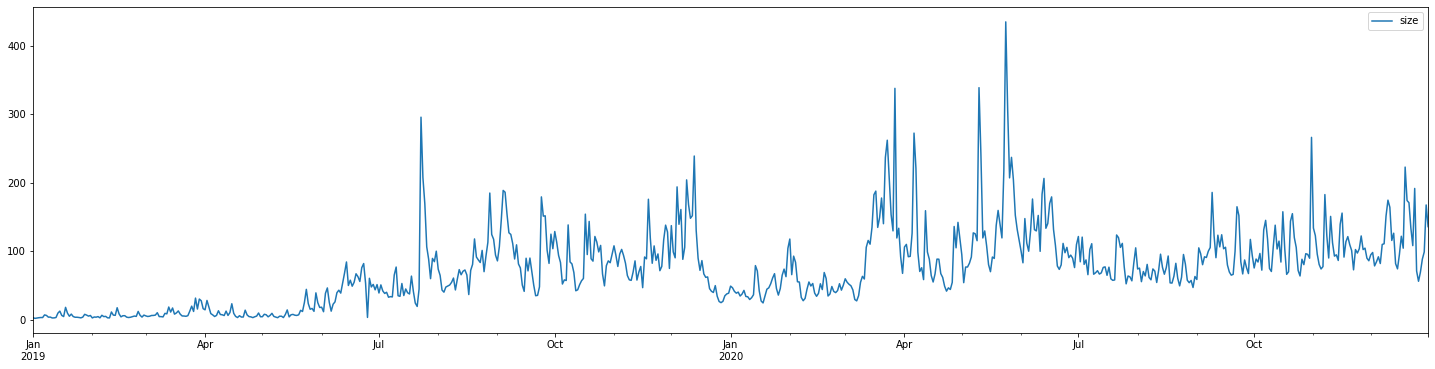

In [28]:
import pandas as pd

file_sizes = {
    datetime.datetime.strptime(file_loc.split('tweets_')[-1].split('.json')[0], '%Y-%m-%d'): 
        os.path.getsize('tweets_data/{}'.format(file_loc)) / 1000000
    for file_loc in os.listdir('tweets_data') if file_loc.endswith('.json')
}
pd.DataFrame(file_sizes, index=['size']).T.plot(kind='line', figsize=(25, 6))

In total we have 54GB corpus.

In [29]:
pd.DataFrame(file_sizes, index=['size']).T['size'].agg(['mean', 'sum'])

mean       74.109401
sum     54173.972202
Name: size, dtype: float64

Check log for missing dates.

In [25]:
logfile = 'twitter_fetching_log_2021-01-07.log'
sdate = datetime.date(2019, 12, 4)
edate = datetime.date(2020, 12, 31)
delta = edate - sdate
dates = [sdate + datetime.timedelta(days=i) for i in range(delta.days + 1)]
dates = [d.strftime('%Y-%m-%d') for d in dates]

with open(logfile, 'r') as f:
    log_txt = f.read()
    
for date in dates:
    if 'Done {}.'.format(date) not in log_txt:
        print('ERROR! {} was never successfully finished, judging by the log file.'.format(date))

If you suspect there are missing dates, run the cells below to backfill the `.json` files.

In [26]:
# missing_dates = [
#     '2020-08-18',  # 1.56 MB
#     '2020-12-19',  # 27.2 MB
# ]

In [27]:
# for date in missing_dates:
#     next_date = (datetime.datetime.strptime(date, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
#     print(date, next_date)
#     _ = fetch_tweets(date, next_date)

2020-08-18 2020-08-19
2020-12-19 2020-12-20
